In [1]:
import matlab.engine
import os

In [2]:
base_path = os.getcwd()  # current working directory
matlab_path = os.path.join(base_path, 'matlab')
enums_path = os.path.join(base_path, 'matlab/enums')
parameters_path = os.path.join(base_path, 'matlab/parameters')

# Start MATLAB engine
eng = matlab.engine.start_matlab()

In [3]:
# Add relative paths to MATLAB engine
eng.addpath(matlab_path, nargout=0)
eng.addpath(enums_path, nargout=0)
eng.addpath(parameters_path, nargout=0)

In [4]:
eng.eval("""
    % Create the simulator object
    simulator = Factory.createSimulator(SimulatorMode.Concentration);
    
    k = 3;
    
    % Display the patient ID
    disp(['Patient id: ', num2str(k)]);
    
    interaction = Interaction.Surface;
    dohMeasure = DoHMeasure.Both;
    modes_TCI =  containers.Map({'prop', 'remi'}, {TciMode.EffectSite, TciMode.EffectSite});

    limits_TCI = containers.Map({'cp_limit_prop', 'cp_limit_remi', 'infusion_limit_prop', 'infusion_limit_remi'}, {20, 10, 2 , 0.5});

    pk_models = containers.Map({'prop', 'remi'}, {Model.Eleveld, Model.Eleveld});
    pd_models = containers.Map({'prop', 'remi'}, {Model.Eleveld, Model.Eleveld});
    
    stimuli = containers.Map('KeyType', 'double', 'ValueType', 'any');

    t_sim = 30 * 60;
    t_s = 5;

    var = {'opiates', true, 'blood_sampling', BloodSampling.ARTERIAL, 'interaction',interaction, 'doh_measure', dohMeasure,'modes_TCI', modes_TCI, 'pk_models', pk_models, 'pd_models', pd_models, 'pk_models_TCI', pk_models, 'pd_models_TCI', pd_models, 'limits_TCI',limits_TCI};

    simulator.init_simulation_from_file(k,t_sim,t_s,var{:});

    target_prop = 2.0*ones(t_sim, 1);
    target_remi = 3.6*ones(t_sim, 1);
    target_nore = 0.5*ones(t_sim, 1);
    target_rocu = 2*ones(t_sim, 1);

    simulator.run_complete_simulation(target_prop, target_remi, target_nore, target_rocu);
    simulator.save_simulation()
""", nargout=0)
# Get the result from MATLAB
matlab_result = eng.eval("simulator.get_patient_results()", nargout=1)

print("MATLAB result:", matlab_result)

Patient id: 3
Patient has entered the maintenance phase
MATLAB result: <matlab.object object at 0x12de6dad0>


In [5]:
# Extract the keys and values from the containers.Map
keys = eng.eval("keys(simulator.get_patient_results())", nargout=1)
values = eng.eval("values(simulator.get_patient_results())", nargout=1)

# Convert MATLAB keys and values into Python lists
py_keys = list(keys)
py_values = list(values)

# Convert the values from matlab.double to Python lists 
for i in range(len(py_values)):
    py_values[i] = [item[0] for item in py_values[i]]  # Flatten the list of lists

# Create a Python dictionary by combining the keys and values
matlab_result = dict(zip(py_keys, py_values))

# Print out the simulation results
print("Simulation results:", matlab_result)

Simulation results: {'bis_all': [93.0, 92.99999961829022, 92.99999481836413, 92.99997632467823, 92.99993071867662, 92.99993071867662, 92.99984117006936, 92.99968795992275, 92.99944889739314, 92.99909966871384, 92.99909966871384, 92.99826561418034, 92.99655936487034, 92.99369166771527, 92.98920559052097, 92.98920559052097, 92.98258295547924, 92.97324929123019, 92.96057587360518, 92.94388082379355, 92.94388082379355, 92.92243051496764, 92.8954417645852, 92.86208484750352, 92.82148719474458, 92.82148719474458, 92.77273761724274, 92.71489092294541, 92.64697283465655, 92.56798514891724, 92.56798514891724, 92.47691109928437, 92.37272090152243, 92.254377465568, 92.1208422616331, 92.1208422616331, 91.97104428441426, 91.80364548479815, 91.61731365634914, 91.41123554664534, 91.41123554664534, 91.18495334418537, 90.93813431871247, 90.67064565838109, 90.38266959852363, 90.38266959852363, 90.07460761153948, 89.7470010637653, 89.40050050957808, 89.03583042420186, 89.03583042420186, 88.65376386761363

In [6]:
# Quit MATLAB engine
eng.quit()

In [7]:
# External library import
!pip install control

In [8]:
# Local libraries import
from python.AReS import Simulator, Model, Interaction, DoHMeasure, SimulatorMode,TciMode, DisturbanceType

import matplotlib.pyplot as plt
import numpy as np

In [9]:
simulator = Simulator.create(SimulatorMode.CONCENTRATION)

k = 2

interaction = Interaction.SURFACE
dohMeasure = DoHMeasure.BOTH
t_sim = 60 * 30
t_s = 5

pk_models = {'prop': Model.ELEVELD, 'remi': Model.ELEVELD}
pd_models = {'prop': Model.ELEVELD, 'remi': Model.ELEVELD}

limits_TCI = {'cp_limit_prop': 20, 'cp_limit_remi': 10, 'infusion_limit_prop': 2,
              'infusion_limit_remi': 0.5}

modes_TCI = {'prop': TciMode.EFFECT_SITE, 'remi': TciMode.EFFECT_SITE}

simulator.init_simulation_from_file(id_patient=k, t_sim=t_sim, t_s=t_s,
                                    pk_models=pk_models, pd_models=pd_models,
                                    pk_models_TCI=pk_models, pd_models_TCI=pd_models,
                                    interaction=interaction, doh_measure=dohMeasure, 
                                    modes_TCI=modes_TCI, limits_TCI=limits_TCI)

target_prop = 2.0 * np.ones(t_sim)
target_remi = 3.6 * np.ones(t_sim)
target_nore = 0.5 * np.ones(t_sim)
target_rocu = 2 * np.ones(t_sim)

simulator.run_complete_simulation(target_prop, target_remi, target_nore, target_rocu)

simulator.save_simulation()

# Get the result from Python
py_results = simulator.get_patient_results()

print("Python result:", py_results)

Python result: {'_BIS_all': [array([93.        , 92.99999962, 92.99999482, ..., 36.31614423,
       36.31508258, 36.31402223])], '_CO_all': [array([5.63413104, 5.63413104, 5.633097  , ..., 4.15313487, 4.15307106,
       4.15300736])], '_HR_all': [array([62.8881    , 62.8881    , 62.88779392, ..., 65.58133121,
       65.58354516, 65.58575593])], '_MAP_all': [array([91.83633601, 91.83633601, 91.81564649, ..., 65.21626346,
       65.21569927, 65.21513632])], '_NMB_m0_all': [array([1.        , 1.        , 1.        , ..., 0.09378014, 0.09376137,
       0.09374262])], '_NMB_m1_all': [array([0.00000000e+00, 8.09422246e-21, 4.11330864e-18, ...,
       2.00926857e-01, 2.00899721e-01, 2.00872605e-01])], '_NMB_m2_all': [array([0.00000000e+00, 2.18903804e-21, 1.11242175e-18, ...,
       4.06034950e-01, 4.06034538e-01, 4.06034118e-01])], '_NMB_m3_all': [array([0.00000000e+00, 4.75473354e-22, 2.41625266e-19, ...,
       2.99258057e-01, 2.99304373e-01, 2.99350660e-01])], '_SV_all': [array([89.58978 

In [10]:
py_results = {key.replace('_', '', 1).lower(): value for key, value in py_results.items()}

# Compare the keys
if matlab_result.keys() == py_results.keys():
    print("The lowercase keys are the same.")
else:
    print("The lowercase keys are different.")
    print("MATLAB keys:", matlab_result.keys())
    print("Python keys:", py_results.keys())

The lowercase keys are the same.


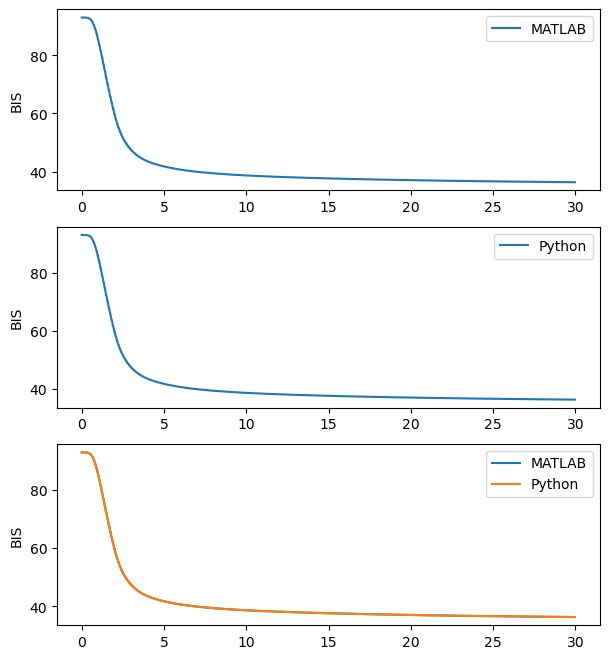

<Figure size 640x480 with 0 Axes>

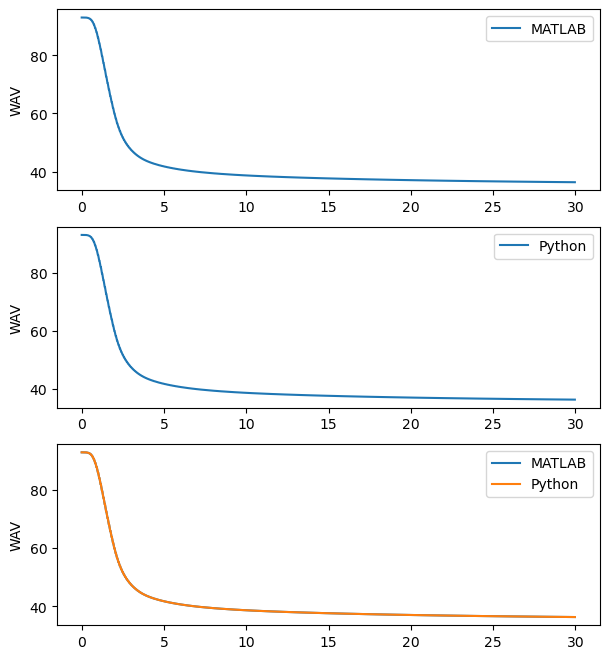

<Figure size 640x480 with 0 Axes>

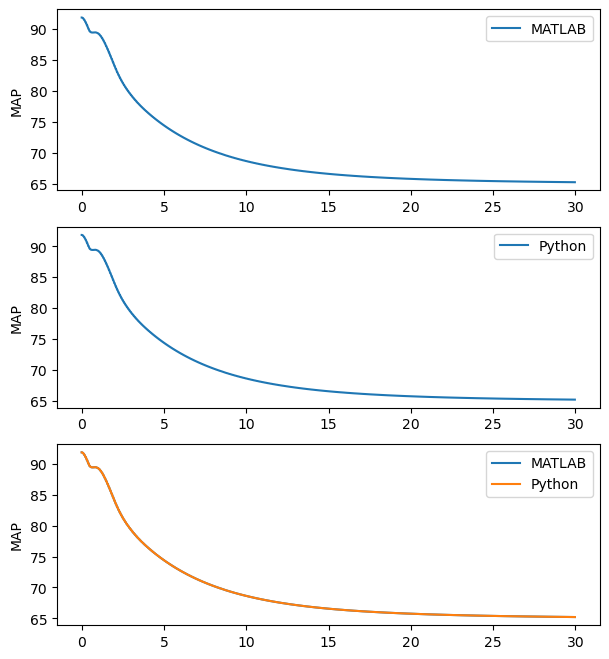

<Figure size 640x480 with 0 Axes>

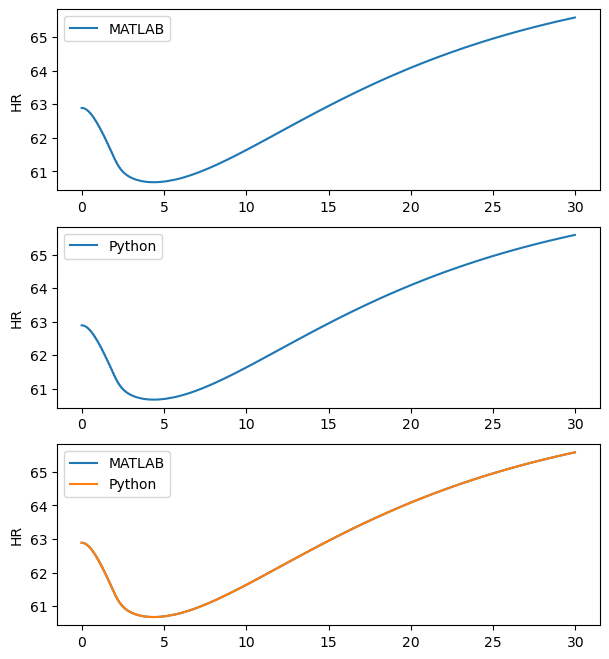

<Figure size 640x480 with 0 Axes>

In [11]:
names = {'bis_all': 'BIS', 'wav_all': 'WAV', 'map_all': 'MAP', 'hr_all': 'HR'}

num_samples = len(matlab_result['bis_all'])
t_sim = np.arange(num_samples-1) / 60

for key in ['bis_all', 'wav_all', 'map_all', 'hr_all']:
    fig, ax = plt.subplots(3, 1, figsize=(7, 8))  # Taller figure for 3 rows

    ax[0].plot(t_sim, matlab_result[key][:-1], label='MATLAB')
    ax[0].set_ylabel(names[key])
    ax[0].legend()

    ax[1].plot(t_sim, py_results[key][0][:-1], label='Python')
    ax[1].set_ylabel(names[key])
    ax[1].legend()

    ax[2].plot(t_sim, matlab_result[key][:-1], label='MATLAB')
    ax[2].plot(t_sim, py_results[key][0][:-1], label='Python')
    ax[2].set_ylabel(names[key])
    ax[2].legend()

    plt.show()
    plt.clf()

In [12]:
import numpy as np

# Set a threshold value
threshold = 0.8

def compare_dicts_with_threshold(dict1, dict2, threshold):
    for key in dict1:
        print("Examining key:", key)
        arr1 = np.array(dict1[key])
        arr2 = np.array(dict2[key])
        print("\n")

        # Compare all elements except the last one
        diff = np.isclose(arr1[:-1], arr2[0][:-1], atol=threshold)

        if not np.all(diff):
            print("Arrays differ at the following indices:")
            differing_indices = np.where(~diff)[0]
            for idx in differing_indices:
                print(f"Min {idx / 60:.0f}: arr1 = {arr1[idx]}, arr2 = {arr2[0][idx]}")
            print("Arrays are not equal within the threshold.\n")


# Compare the two dictionaries
compare_dicts_with_threshold(matlab_result, py_results, threshold)


Examining key: bis_all


Examining key: c_nore_all


Examining key: ce_bis_all


Examining key: ce_del_all


Examining key: ce_prop_all


Examining key: ce_remi_all


Examining key: ce_rocu_all


Examining key: ce_wav_all


Examining key: co_all


Examining key: cp_prop_all


Examining key: cp_remi_all


Examining key: cp_rocu_all


Examining key: hr_all


Examining key: map_all


Examining key: nmb_m0_all


Examining key: nmb_m1_all


Examining key: nmb_m2_all


Examining key: nmb_m3_all


Examining key: sv_all


Examining key: tpr_all


Examining key: u_nore_all


Examining key: u_prop_all


Examining key: u_remi_all


Examining key: u_rocu_all


Examining key: wav_all


